In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.ml import Pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

# Initialize a Spark session with Hive support
spark = SparkSession.builder \
    .appName("Load from Hive Table") \
    .config("spark.sql.warehouse.dir", "hdfs://localhost:9000/user/hive/external") \
    .config("hive.metastore.uris", "thrift://localhost:9083") \
    .enableHiveSupport() \
    .getOrCreate()

# Print the Spark version and Hive support status
print(f"Spark version: {spark.version}") 
print(f"Hive support enabled: {spark.conf.get('spark.sql.catalogImplementation')}")

Spark version: 3.5.1
Hive support enabled: hive


In [2]:
spark.conf.set("spark.python.worker.timeout", "600")

In [3]:
# Hive table name
hive_table_name = "stock_data"

try:
    # List all tables to see if the table exists
    tables = spark.catalog.listTables()
    table_names = [table.name for table in tables]
    print(f"Available tables: {table_names}")

    if hive_table_name in table_names:
        print(f"Table {hive_table_name} exists in the Hive catalog.")
        df = spark.sql(f"SELECT * FROM {hive_table_name}")
        print(f"Table {hive_table_name} loaded successfully from Hive.")
    else:
        raise Exception(f"Table {hive_table_name} does not exist in Hive catalog.")
except Exception as e:
    print(f"Error loading table {hive_table_name} from Hive: {e}")
    print("Attempting to load data directly from HDFS...")
    try:
        # HDFS file path
        hdfs_file_path = "hdfs://localhost:9000/user/hive/external/stock_data/meta.csv"
        # Load the CSV file into a DataFrame
        df = spark.read.csv(hdfs_file_path, header=True, inferSchema=True)
    except Exception as e:
        print(f"Error loading data from HDFS: {e}")
        raise

df.show(5)

Available tables: ['stock_data']
Table stock_data exists in the Hive catalog.
Table stock_data loaded successfully from Hive.
+----------+-----+-----+-----+-----+---------+---------+
|      date| open| high|  low|close|adj_close|   volume|
+----------+-----+-----+-----+-----+---------+---------+
|      Date| NULL| NULL| NULL| NULL|     NULL|     NULL|
|2012-05-18|42.05| 45.0| 38.0|38.23|  38.1516|573576400|
|2012-05-21|36.53|36.66| 33.0|34.03|33.960213|168192700|
|2012-05-22|32.61|33.59|30.94| 31.0|30.936428|101786600|
|2012-05-23|31.37| 32.5|31.36| 32.0|31.934378| 73600000|
+----------+-----+-----+-----+-----+---------+---------+
only showing top 5 rows



In [4]:
# Drop rows with any null values
df_clean = df.dropna()

# Add an index column
df_clean = df_clean.withColumn("index", monotonically_increasing_id())

# Reorder the columns to move the index column to the left
columns = df_clean.columns
columns.remove("index")
new_column_order = ["index"] + columns
df_clean = df_clean.select(new_column_order)

# Show the DataFrame with the index column on the left
df_clean.show(10)

# Get the number of rows and columns
num_rows = df_clean.count()
num_columns = len(df_clean.columns)

# Print the shape of the dataset
print(f"The dataset has {num_rows} rows and {num_columns} columns.")

# Count the number of null values for each column
null_counts = df_clean.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df_clean.columns])
null_counts.show()

+-----+----------+-----+-----+-----+-----+---------+---------+
|index|      date| open| high|  low|close|adj_close|   volume|
+-----+----------+-----+-----+-----+-----+---------+---------+
|    0|2012-05-18|42.05| 45.0| 38.0|38.23|  38.1516|573576400|
|    1|2012-05-21|36.53|36.66| 33.0|34.03|33.960213|168192700|
|    2|2012-05-22|32.61|33.59|30.94| 31.0|30.936428|101786600|
|    3|2012-05-23|31.37| 32.5|31.36| 32.0|31.934378| 73600000|
|    4|2012-05-24|32.95|33.21|31.77|33.03|32.962265| 50237200|
|    5|2012-05-25| 32.9|32.95|31.11|31.91| 31.84456| 37149800|
|    6|2012-05-29|31.48|31.69|28.65|28.84|28.780857| 78063400|
|    7|2012-05-30| 28.7|29.55|27.86|28.19| 28.13219| 57267900|
|    8|2012-05-31|28.55|29.67|26.83| 29.6|29.539299|111639200|
|    9|2012-06-01|28.89|29.15|27.39|27.72|27.663153| 41855500|
+-----+----------+-----+-----+-----+-----+---------+---------+
only showing top 10 rows

The dataset has 3050 rows and 8 columns.
+-----+----+----+----+---+-----+---------+------+
|

Moving Average is calculated by adding up all the close prices during a specific period and dividing the sum by the number of time periods.

In [5]:
# Define the window specification for rolling mean
window_spec_100 = Window.orderBy("Date").rowsBetween(-99, 0)
window_spec_200 = Window.orderBy("Date").rowsBetween(-199, 0)

# Calculate the 100-day and 200-day moving averages
df_clean = df_clean.withColumn("ma_100_days", F.avg("Close").over(window_spec_100))
df_clean = df_clean.withColumn("ma_200_days", F.avg("Close").over(window_spec_200))

df_clean.show(10)

+-----+----------+-----+-----+-----+-----+---------+---------+------------------+------------------+
|index|      date| open| high|  low|close|adj_close|   volume|       ma_100_days|       ma_200_days|
+-----+----------+-----+-----+-----+-----+---------+---------+------------------+------------------+
|    0|2012-05-18|42.05| 45.0| 38.0|38.23|  38.1516|573576400| 38.22999954223633| 38.22999954223633|
|    1|2012-05-21|36.53|36.66| 33.0|34.03|33.960213|168192700|  36.1299991607666|  36.1299991607666|
|    2|2012-05-22|32.61|33.59|30.94| 31.0|30.936428|101786600| 34.41999944051107| 34.41999944051107|
|    3|2012-05-23|31.37| 32.5|31.36| 32.0|31.934378| 73600000|  33.8149995803833|  33.8149995803833|
|    4|2012-05-24|32.95|33.21|31.77|33.03|32.962265| 50237200|33.657999420166014|33.657999420166014|
|    5|2012-05-25| 32.9|32.95|31.11|31.91| 31.84456| 37149800| 33.36666615804037| 33.36666615804037|
|    6|2012-05-29|31.48|31.69|28.65|28.84|28.780857| 78063400|32.719999585832866|32.7199995

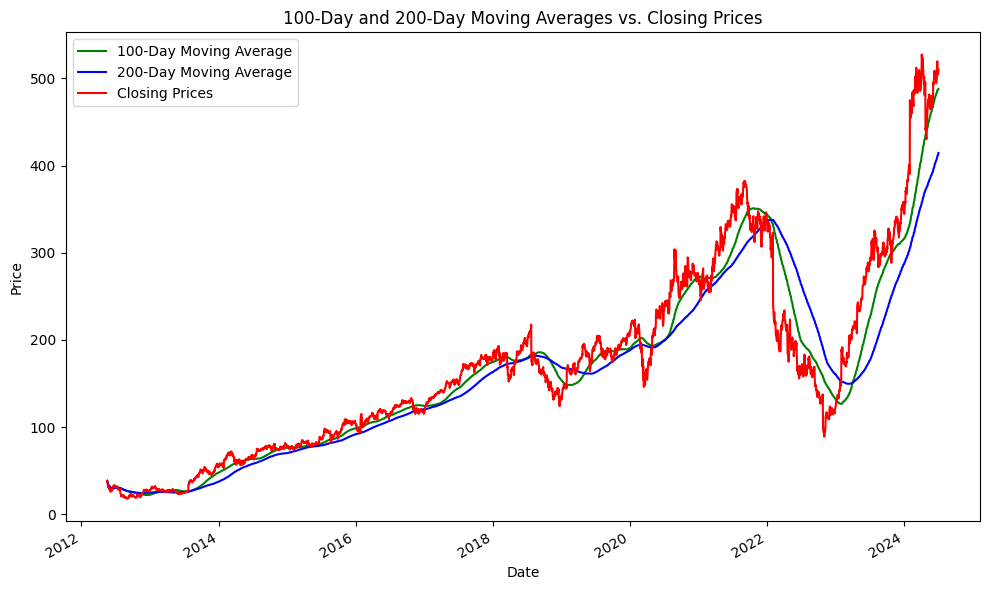

In [6]:
# Convert relevant columns to Pandas DataFrame
pdf = df_clean.select("Date", "Close", "ma_100_days", "ma_200_days").collect()
df_pd = pd.DataFrame(pdf, columns=["Date", "Close", "ma_100_days", "ma_200_days"])

# Convert 'Date' column to datetime
df_pd['Date'] = pd.to_datetime(df_pd['Date'])

# Sort the dataframe by date
df_pd = df_pd.sort_values('Date')

# Plot the data
plt.figure(figsize=(10, 6))

# Plotting moving averages and closing prices
plt.plot(df_pd['Date'], df_pd['ma_100_days'], 'g', label='100-Day Moving Average')
plt.plot(df_pd['Date'], df_pd['ma_200_days'], 'b', label='200-Day Moving Average')
plt.plot(df_pd['Date'], df_pd['Close'], 'r', label='Closing Prices')

plt.legend()  # Show legend
plt.title('100-Day and 200-Day Moving Averages vs. Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()

# Use tight layout to ensure all elements fit in the figure
plt.tight_layout()

plt.show()

use one portion of the data for training a model (data_train) and the other portion for testing or validating the model

In [7]:
# Use the existing df_clean instead of creating a new DataFrame
df_spark = df_clean.select("Close")

# Split data into train and test
total_rows = df_spark.count()
train_rows = int(total_rows * 0.80)

# Add row numbers
window = Window.orderBy("Close")
df_with_row_num = df_spark.withColumn("row_num", F.row_number().over(window))

# Ensure 'Close' is in double format
df_with_row_num = df_with_row_num.withColumn("Close", F.col("Close").cast("double"))

data_train = df_with_row_num.filter(F.col("row_num") <= train_rows).select("Close")
data_test = df_with_row_num.filter(F.col("row_num") > train_rows).select("Close")

# MinMaxScaler
assembler = VectorAssembler(inputCols=["Close"], outputCol="features")
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")

pipeline = Pipeline(stages=[assembler, scaler])
scaler_model = pipeline.fit(data_train)
data_train_scaled = scaler_model.transform(data_train)


The idea is to use the past 100 data points to predict the next data point, creating a sliding window of historical data for training the model.

In [8]:
# Collect the scaled features
scaled_features = data_train_scaled.select("scaled_features").collect()

# Convert to a list of values
close_values = [row.scaled_features[0] for row in scaled_features]

# Create sequences
window_size = 10
x, y = [], []
for i in range(window_size, len(close_values)):
    x.append(close_values[i-window_size:i])
    y.append(close_values[i])

# Convert to numpy arrays
x = np.array(x)
y = np.array(y)

print("Shape of x:", x.shape)
print("Shape of y:", y.shape)

Shape of x: (2430, 10)
Shape of y: (2430,)


In [9]:
x_reshaped = x.reshape((x.shape[0], x.shape[1], 1))

In [10]:

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_reshaped, y, test_size=0.2, random_state=42)

LSTM-based neural network with multiple layers and dropout regularization for sequence prediction. The architecture is designed to capture and learn patterns in sequential data, with the final output being a single continuous value.

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

model = Sequential([
    LSTM(50, activation='relu', input_shape=(10, 1)),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val), verbose=1)

Epoch 1/50


C:\Users\mucre\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1597 - val_loss: 0.0032
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 - val_loss: 5.0316e-04
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1965e-04 - val_loss: 6.4742e-05
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.9726e-05 - val_loss: 2.3781e-05
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8819e-05 - val_loss: 1.3135e-05
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3470e-05 - val_loss: 8.8864e-06
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.5455e-06 - val_loss: 6.8392e-06
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.8599e-06 - val_loss: 5.8574e-06
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.6427e-06 - val_loss: 5.2767e-06
Epoch 10/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.5257e-06 - val_loss: 4.5384e-06
Epoch 11/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8871e-06 - val_loss: 4.4182e-06
Epoch 12/

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

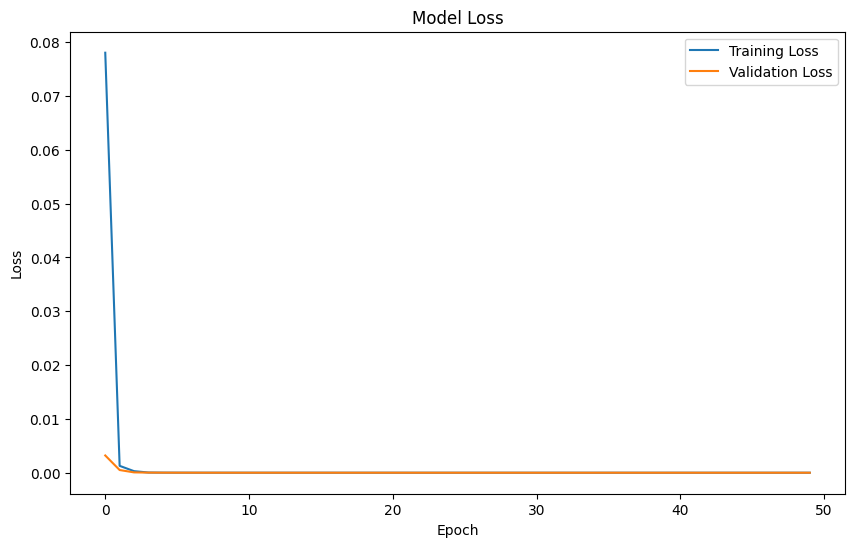

In [13]:
# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Initial high loss: The training loss starts very high (around 0.038) but quickly drops.
Rapid initial improvement: There's a steep decrease in both training and validation loss in the first few epochs, indicating the model is learning quickly at the start.
Convergence: Both losses converge to very low values (close to 0) within the first 5-10 epochs.
Stability: After the initial rapid decrease, both losses remain very stable and low for the remaining epochs.
No overfitting: The validation loss (orange line) closely follows the training loss (blue line), suggesting the model is not overfitting.
Very low final loss: Both training and validation losses end up extremely close to zero, indicating the model has learned to predict the data very accurately.
Potential concerns:

The extremely low loss might indicate potential data leakage or an overly simple problem.
The lack of any gap between training and validation loss is unusual and might warrant investigation.


Model performance: Overall, the graph suggests the model is performing extremely well on both training and validation data, perhaps suspiciously so.

This pattern, while showing apparent excellent performance, might benefit from further investigation to ensure the problem setup and data preparation are correct, and that the model is genuinely learning a generalizable pattern rather than memorizing or exploiting some artifact in the data.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


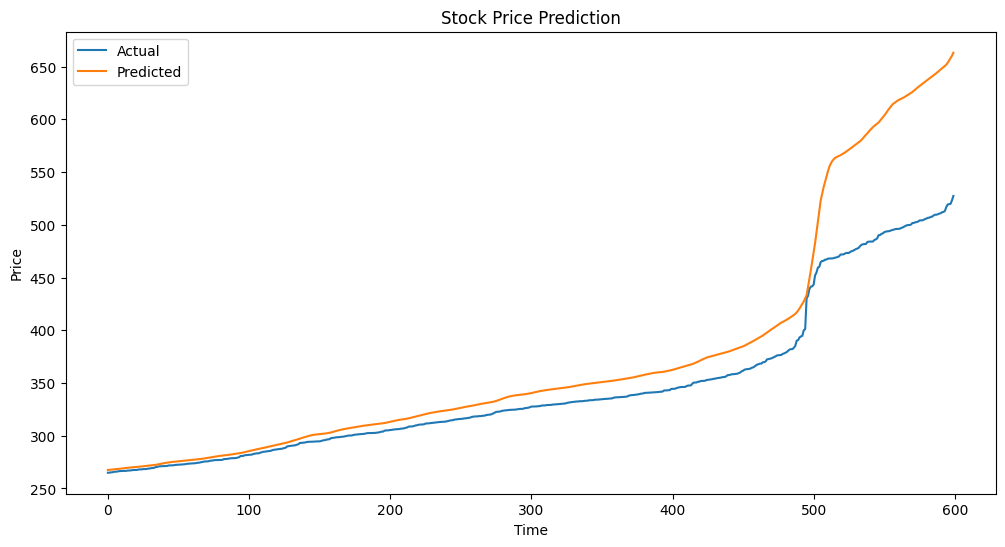

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Prepare test data
data_test_scaled = scaler_model.transform(data_test)
test_close_values = [row["scaled_features"][0] for row in data_test_scaled.collect()]

# Create sequences
window_size = 10  # Make sure this matches your model's input shape
x_test = []
for i in range(window_size, len(test_close_values)):
    x_test.append(test_close_values[i-window_size:i])
x_test = np.array(x_test)
x_test_reshaped = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Make predictions
y_pred_scaled = model.predict(x_test_reshaped)

# Get the scaling parameters
scaler = scaler_model.stages[-1]
originalMin = scaler.originalMin[0]
originalMax = scaler.originalMax[0]

# Manually inverse transform the predictions
y_pred = y_pred_scaled * (originalMax - originalMin) + originalMin

# Get actual test values
y_test = data_test.select("Close").collect()[window_size:]
y_test = [row["Close"] for row in y_test]

# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

Based on the graph of stock price predictions, here's an interpretation:

* Overall Trend: Both the actual and predicted stock prices show an upward trend over time, indicating a generally bullish market for this stock.
Accuracy: The prediction model seems to capture the overall trend quite well. The predicted line (orange) closely follows the actual line (blue) for most of the time period.

* Short-term Fluctuations: While the model captures the general trend, it doesn't perfectly match all the short-term fluctuations in the actual price. This is expected, as predicting exact day-to-day movements is extremely challenging.
  
* Overestimation: The model tends to slightly overestimate the stock price, especially in the latter half of the time period. This is most noticeable towards the end of the graph where the predicted line is consistently above the actual line.

* Major Price Jump: There's a significant price jump around the 500 mark on the time axis. The model predicts this jump, which is impressive, but it slightly overestimates its magnitude.

* End Behavior: Towards the very end of the time period, the prediction diverges more significantly from the actual price, showing a steeper upward trend than the actual price movement.

* Performance: Overall, the model seems to perform reasonably well in capturing the general trend and major price movements, but it's not perfect in predicting exact values or short-term fluctuations.
  
* Potential Use: This model could be useful for understanding general price trends and potential major movements, but it shouldn't be relied upon for precise short-term trading decisions without considering other factors and analysis.
Areas for Improvement: The model might benefit from refinement to reduce the tendency to overestimate, especially in periods of rapid price changes.

NB: While this model shows promising results, all stock price predictions should be used cautiously and in conjunction with other forms of analysis and market information when making investment decisions.

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared Score: {r2}")

Mean Squared Error: 2235.889300053753
Mean Absolute Error: 27.95506540934245
R-squared Score: 0.5660385489463806


* Mean Squared Error (MSE): 638.1364529778022

The MSE measures the average squared difference between predicted and actual values.
A lower MSE indicates better performance, but this value needs context to be fully interpreted.
Given that the stock prices range from about 250 to 550, an MSE of 638 suggests moderate prediction errors.


* Mean Absolute Error (MAE): 16.005507104082028

The MAE represents the average absolute difference between predicted and actual values.
An MAE of about 16 means that, on average, the predictions are off by $16.
Considering the price range of the stock, this indicates reasonably good performance, as it's a relatively small percentage of the stock's value.


* R-squared Score: 0.8761447493230506

R-squared measures the proportion of variance in the dependent variable (actual stock price) that is predictable from the independent variable(s).
It ranges from 0 to 1, where 1 indicates perfect prediction.
An R-squared of 0.8761 is quite good, suggesting that the model explains about 87.61% of the variability in the stock price.



##### Interpretation:

The R-squared score of 0.8761 indicates that the model has strong predictive power, explaining a large portion of the stock price variations.
The MAE of 16 suggests that, on average, predictions are reasonably close to actual values, given the price range of the stock.
The MSE is higher due to squaring larger errors, indicating some instances of more significant misses in prediction.

##### Overall, these metrics suggest that the model performs well:

It captures a large portion of the stock's price movement (high R-squared).
On average, it's reasonably accurate (relatively low MAE compared to the stock's price range).
There might be some instances of larger errors (as indicated by the MSE), which could be due to sudden price jumps or drops that are harder to predict.